In [2]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
import tensorflow
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=gpu*"
import numpy as np
# import theano as th
#import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, random, sys, keras

Using TensorFlow backend.


In [3]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = cPickle.load(open("RML2016.10a_dict.dat",'rb'))
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [4]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
n_examples =X.shape[0]
n_train =int(n_examples * 0.5) 
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

In [5]:
in_shp = list(X_train.shape[1:])
print X_train.shape, in_shp
classes = mods

(110000, 2, 128) [2, 128]


In [6]:
dr = 0.5  # dropout rate (%) 卷积层部分  https://keras-cn.readthedocs.io/en/latest/layers/convolutional_layer/#conv2d
model = models.Sequential()  # 这里使用keras的序贯模型  https://keras-cn.readthedocs.io/en/latest/models/sequential/
# Reshape [N,2,128] to [N,1,2,128] on input
model.add(Reshape(([1] + in_shp), input_shape=in_shp))
model.add(ZeroPadding2D((0, 2), data_format="channels_first"))
# 卷积核维度(输出尺度),卷积核的宽度和长度,“valid”代表只进行有效的卷积，即对边界数据不处理,
# 层权重weights的初始化函数
# channels_first corresponds to inputs with shape (batch, channels, height, width).
model.add(Convolution2D(256, (1, 3), padding='valid', activation="relu", name="conv1", init='glorot_uniform',
                 data_format="channels_first"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2), data_format="channels_first"))
model.add(Convolution2D(80, (2, 3), padding="valid", activation="relu", name="conv2", init='glorot_uniform',
                 data_format="channels_first"))
model.add(Dropout(dr))
# 多维的输入一维化，常用在从卷积层到全连接层的过渡
model.add(Flatten())
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense(len(classes), init='he_normal', name="dense2"))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

/home/mao/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), kernel_initializer="glorot_uniform", name="conv1", activation="relu", data_format="channels_first", padding="valid")`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 256, 2, 134)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 1, 132)        122960    
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 1, 132)        0         
__________

/home/mao/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 3), kernel_initializer="glorot_uniform", name="conv2", activation="relu", data_format="channels_first", padding="valid")`
  
/home/mao/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="he_normal", activation="relu", name="dense1")`
/home/mao/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(11, kernel_initializer="he_normal", name="dense2")`


In [7]:
# Set up some params 
epochs = 100     # number of epochs to train on
batch_size = 1024 # training batch size

In [8]:
filepath = "convmodrecnets_%s_0.5.wts.h5" # (name)  # 所要保存的文件名字，h5格式，不用写路径，默认在程序执行的文件夹内
history = model.fit(X_train,
                    Y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    verbose=2,
                    validation_data=(X_test, Y_test),
                    callbacks=[  # 回调函数，https://keras-cn.readthedocs.io/en/latest/other/callbacks/
                        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                                                        mode='auto'),
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                    ])  # EarlyStopping 当监测值不再改善时，该回调函数将中止训练，如去除本行将执行所有epoch

/home/mao/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 110000 samples, validate on 110000 samples
Epoch 1/100
 - 10s - loss: 2.2425 - val_loss: 2.0840
Epoch 2/100
 - 8s - loss: 2.0191 - val_loss: 1.8850
Epoch 3/100
 - 8s - loss: 1.8667 - val_loss: 1.7499
Epoch 4/100
 - 8s - loss: 1.7592 - val_loss: 1.6433
Epoch 5/100
 - 8s - loss: 1.6654 - val_loss: 1.5474
Epoch 6/100
 - 8s - loss: 1.6030 - val_loss: 1.4976
Epoch 7/100
 - 8s - loss: 1.5524 - val_loss: 1.4354
Epoch 8/100
 - 8s - loss: 1.5133 - val_loss: 1.3994
Epoch 9/100
 - 8s - loss: 1.4893 - val_loss: 1.3829
Epoch 10/100
 - 8s - loss: 1.4682 - val_loss: 1.3641
Epoch 11/100
 - 8s - loss: 1.4542 - val_loss: 1.3494
Epoch 12/100
 - 8s - loss: 1.4374 - val_loss: 1.3721
Epoch 13/100
 - 8s - loss: 1.4261 - val_loss: 1.3357
Epoch 14/100
 - 8s - loss: 1.4192 - val_loss: 1.3379
Epoch 15/100
 - 8s - loss: 1.4119 - val_loss: 1.3190
Epoch 16/100
 - 8s - loss: 1.4021 - val_loss: 1.3121
Epoch 17/100
 - 8s - loss: 1.3956 - val_loss: 1.3204
Epoch 18/100
 - 8s - loss: 1.3911 - val_loss: 1.3075
Ep

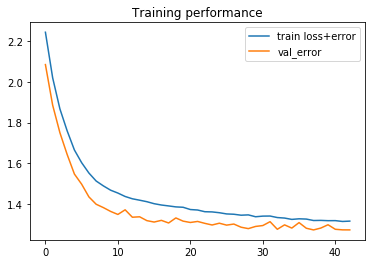

In [11]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.savefig('%s Training performance' )

In [12]:
model.load_weights(filepath)
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print('evaluate_score:', score)

('evaluate_score:', 1.2735298257914456)


In [15]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title)
    plt.show()

In [16]:
test_Y_hat = model.predict(X_test, batch_size=batch_size)

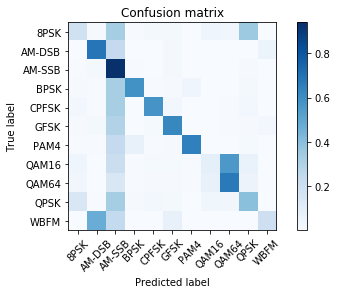

In [17]:
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

<Figure size 432x288 with 0 Axes>

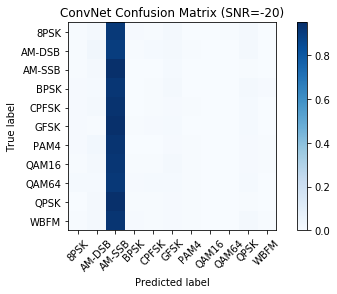

Overall Accuracy:  0.09231609613983977


<Figure size 432x288 with 0 Axes>

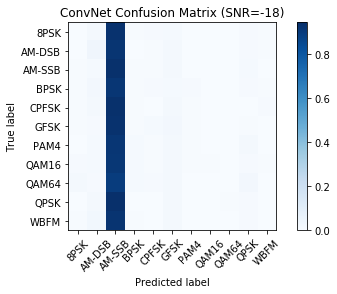

Overall Accuracy:  0.0911262171596546


<Figure size 432x288 with 0 Axes>

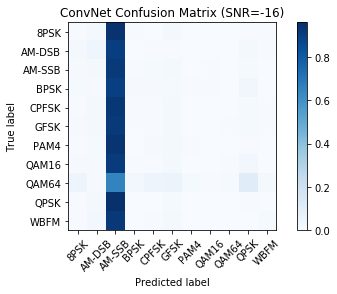

Overall Accuracy:  0.09127418765972983


<Figure size 432x288 with 0 Axes>

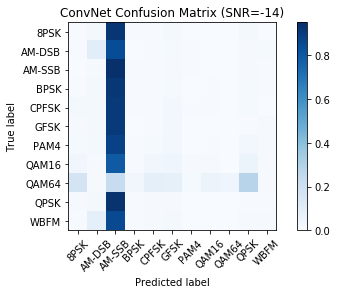

Overall Accuracy:  0.10965391621129326


<Figure size 432x288 with 0 Axes>

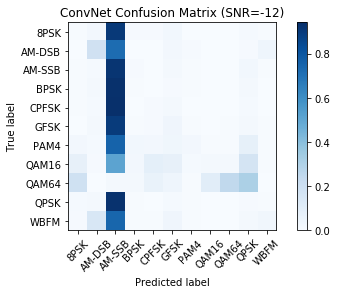

Overall Accuracy:  0.13806104129263913


<Figure size 432x288 with 0 Axes>

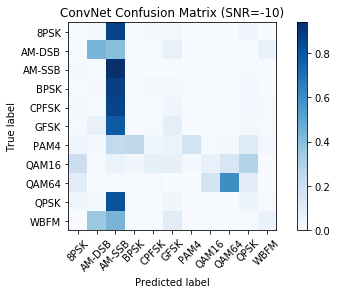

Overall Accuracy:  0.22584784601283225


<Figure size 432x288 with 0 Axes>

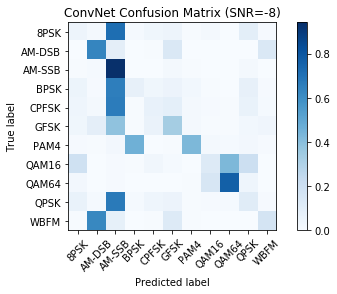

Overall Accuracy:  0.32659065833026846


<Figure size 432x288 with 0 Axes>

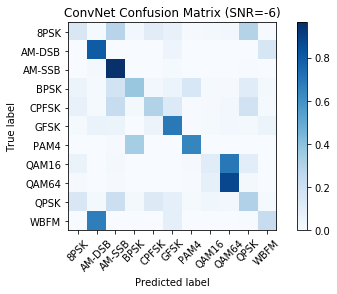

Overall Accuracy:  0.49320851688693096


<Figure size 432x288 with 0 Axes>

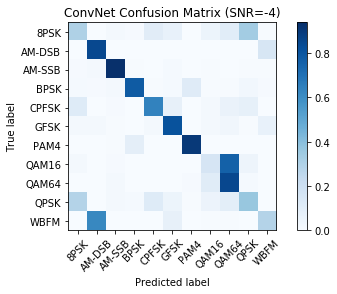

Overall Accuracy:  0.6278092453864426


<Figure size 432x288 with 0 Axes>

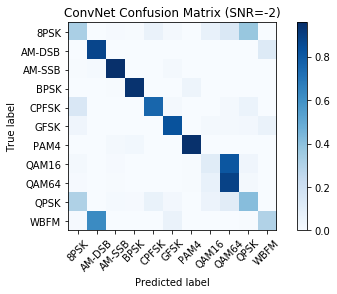

Overall Accuracy:  0.6734177215189874


<Figure size 432x288 with 0 Axes>

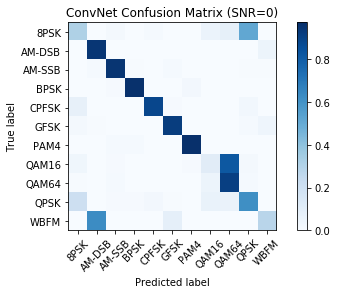

Overall Accuracy:  0.7168608885651857


<Figure size 432x288 with 0 Axes>

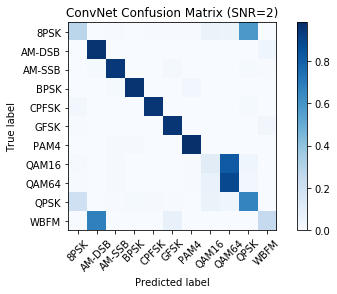

Overall Accuracy:  0.7184766763848397


<Figure size 432x288 with 0 Axes>

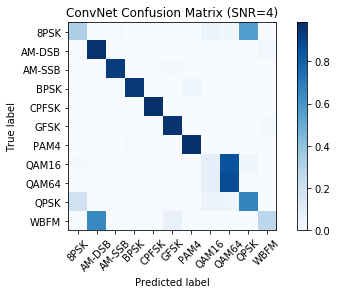

Overall Accuracy:  0.733381372725635


<Figure size 432x288 with 0 Axes>

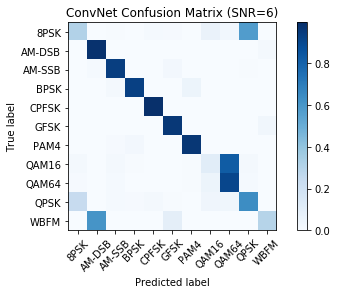

Overall Accuracy:  0.7279331638212859


<Figure size 432x288 with 0 Axes>

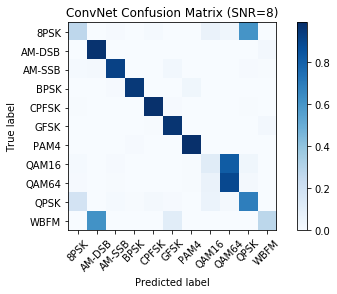

Overall Accuracy:  0.7288840658346898


<Figure size 432x288 with 0 Axes>

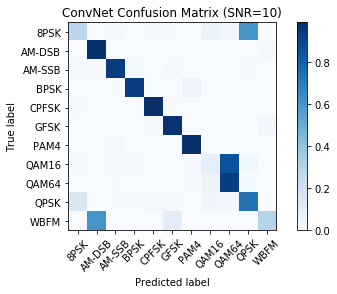

Overall Accuracy:  0.7388627308946034


<Figure size 432x288 with 0 Axes>

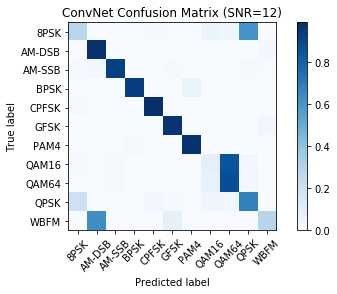

Overall Accuracy:  0.723538990410711


<Figure size 432x288 with 0 Axes>

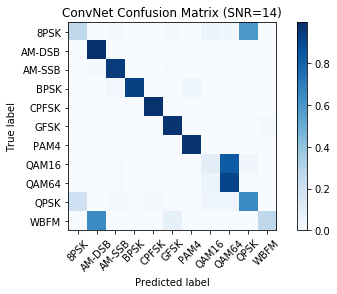

Overall Accuracy:  0.7249455337690632


<Figure size 432x288 with 0 Axes>

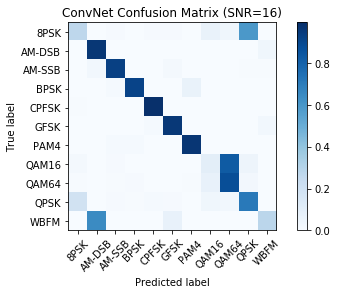

Overall Accuracy:  0.7266642547033285


<Figure size 432x288 with 0 Axes>

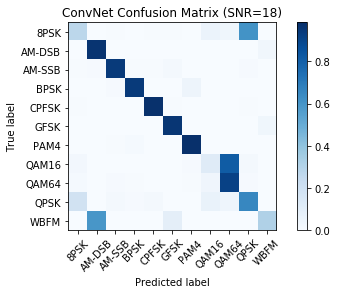

Overall Accuracy:  0.7295733911785972


In [18]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print "Overall Accuracy: ", cor / (cor+ncor)
    acc[snr] = 1.0*cor/(cor+ncor)

In [19]:
# Save results to a pickle file for plotting later
print acc
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{0: 0.7168608885651857, 16: 0.7266642547033285, 2: 0.7184766763848397, 4: 0.733381372725635, 6: 0.7279331638212859, 8: 0.7288840658346898, 12: 0.723538990410711, 10: 0.7388627308946034, -20: 0.09231609613983977, 18: 0.7295733911785972, -18: 0.0911262171596546, -16: 0.09127418765972983, -14: 0.10965391621129326, -12: 0.13806104129263913, 14: 0.7249455337690632, -10: 0.22584784601283225, -8: 0.32659065833026846, -6: 0.49320851688693096, -4: 0.6278092453864426, -2: 0.6734177215189874}


Text(0.5,1,'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

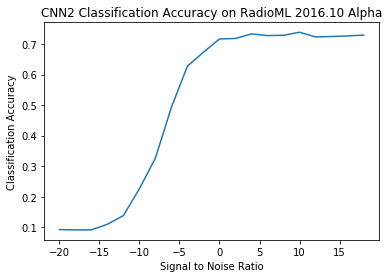

In [20]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")